<h1>DengAI data at first glance<h1>

The DengAI data set is part of the competition on DrivenData website. The goal is to predict the number of infected people (total_cases label) every week for each of the two cities in the test set. There are two cities, San Juan and Iquitos, with test data spanning 5 and 3 years respectively. Throughout, missing values have been filled as NaNs.

In the training set, there are several groups of well-defined features:

- NOAA's GHCN daily climate data weather station measurements
- PERSIANN satellite precipitation measurements
- Satellite vegetation Normalized Difference Vegetation Index (NDVI)

This is a time-series dataset, and all features are reported weekly. Since Dengue fever is an infective disease spread by mosquitos, it is not unreasonable to assume that the weekly number of cases depends on the number of cases from previous weeks and climate parameters even further in the past.

In [48]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
import cufflinks as cf 
%matplotlib inline 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline

import matplotlib.pylab as plt
import datetime

import missingno as msno 
from scipy.interpolate import interp1d

plt.rcParams['figure.figsize'] = [20, 5]

In [44]:
cases_weekly = pd.read_csv(r'/home/milica/Desktop/competition 2/data/dengue_labels_train.csv')
features = pd.read_csv(r'/home/milica/Desktop/competition 2/data/dengue_features_train.csv')

print('features columns:', features.columns)
print('cases_weekly columns:', cases_weekly.columns)

feature columns: Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')
cases_weekly columns: Index(['city', 'year', 'weekofyear', 'total_cases'], dtype='object')


How does the number of infected (our response variable) look like?  

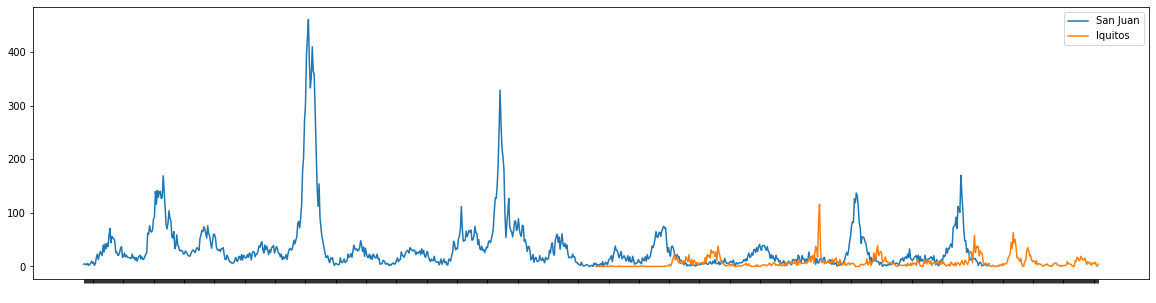

In [60]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=sj.week_start_date, y=sj.total_cases, mode='lines', name='San Juan'))
# fig.add_trace(go.Scatter(x=iq.week_start_date, y=iq.total_cases, mode='lines', name='Iquitos'))
# fig.update_layout(title='Deng fever records', xaxis_title='Week of the year', yaxis_title = 'Number of cases')

plt.plot(features['week_start_date'].loc[features.city == 'sj'], cases_weekly['total_cases'].loc[cases_weekly.city == 'sj'], label='San Juan')
plt.plot(features['week_start_date'].loc[features.city == 'iq'], cases_weekly['total_cases'].loc[cases_weekly.city == 'iq'], label='Iquitos')
plt.xticks(color='w')
plt.legend()
plt.show()

First, let's move data around a bit.

Here we have data for two cities. San Juan (Puerto Rico) and Iquitos (Peru). Let's devide the data into separate dataframes since cities need to be analyzed separately.

Also, on the time axes we have time measured in weeks of the year which doesn't seem so informative. Let's index data by date.


In [61]:
features.drop(['year', 'weekofyear'], axis=1, inplace=True)

In [62]:
print('Shape of casses weekly df:', cases_weekly.shape, 'Shape of df features:',features.shape)
data = pd.concat([cases_weekly.total_cases, features], axis=1) 

sj = data.loc[data['city'] == 'sj']
iq = data.loc[data['city'] == 'iq']

print('Shape of San Juan:', sj.shape, 'Shape of Inquitos:', iq.shape)

Shape of casses weekly df: (1456, 4) Shape of df features: (1456, 22)
Shape of San Juan: (936, 23) Shape of Inquitos: (520, 23)


Let's see how the number of cases behaves throughout the years for both cities.

############## Since Plotly refuses to work with Jupyter, we'll plot the regular matplotlib plot.

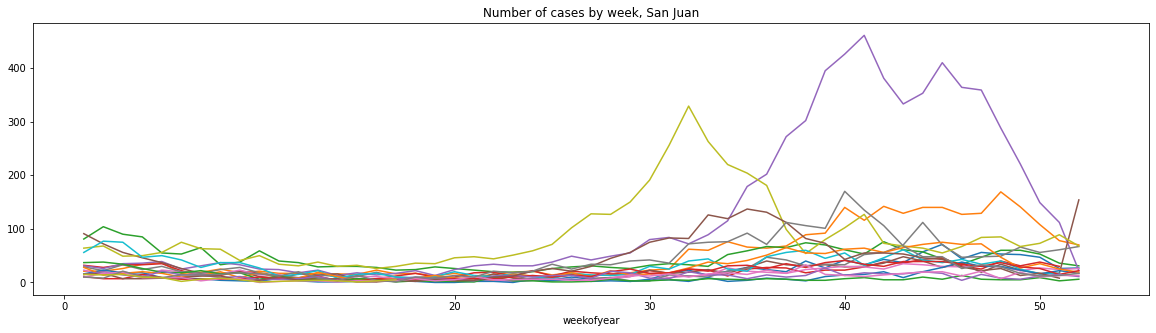

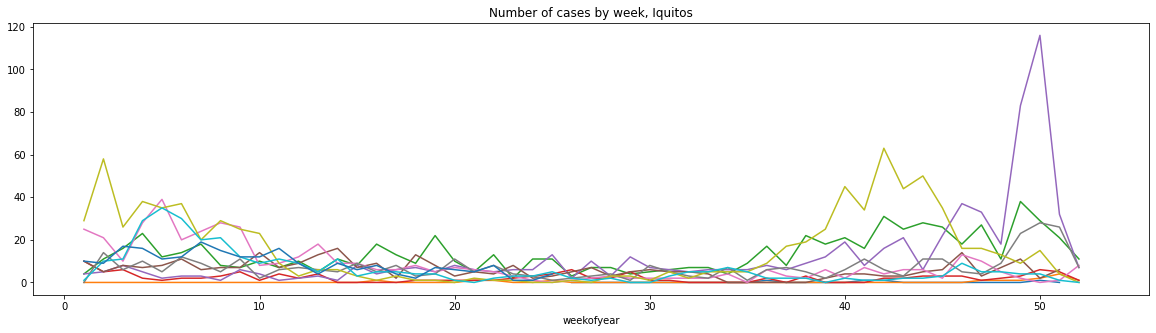

In [74]:
cases_yearly_sj = cases_weekly.loc[data['city'] == 'sj'].pivot_table(cases_weekly.loc[data['city'] == 'sj'],  index=['weekofyear'],columns=['year'])
cases_yearly_iq = cases_weekly.loc[data['city'] == 'iq'].pivot_table(cases_weekly.loc[data['city'] == 'iq'],  index=['weekofyear'],columns=['year'])

cases_yearly_sj.plot(legend=None, title='Number of cases by week, San Juan')
plt.show()
cases_yearly_iq.plot(legend=None, title='Number of cases by week, Iquitos')
plt.show()


If we plot data yearly, we can investigate whether Deng fewer behaves as a seasonal illness. There is a slight pattern, it seems that there are a bit more cases in the beginning and towards the end of the year, but those patterns seem muted by extremely high numbers of cases in some years.

Although some seasonality can be noticed, there is no trend. Also, there are way fewer records for Iquitos than San Juan. It seems that there is no reason to compare the cities for now. 

This dataset has nicely engineered and clearly grouped features. Let's see how does the number of cases follows other variables separately, by the city.

But first, let's deal with missing values.

<AxesSubplot:>

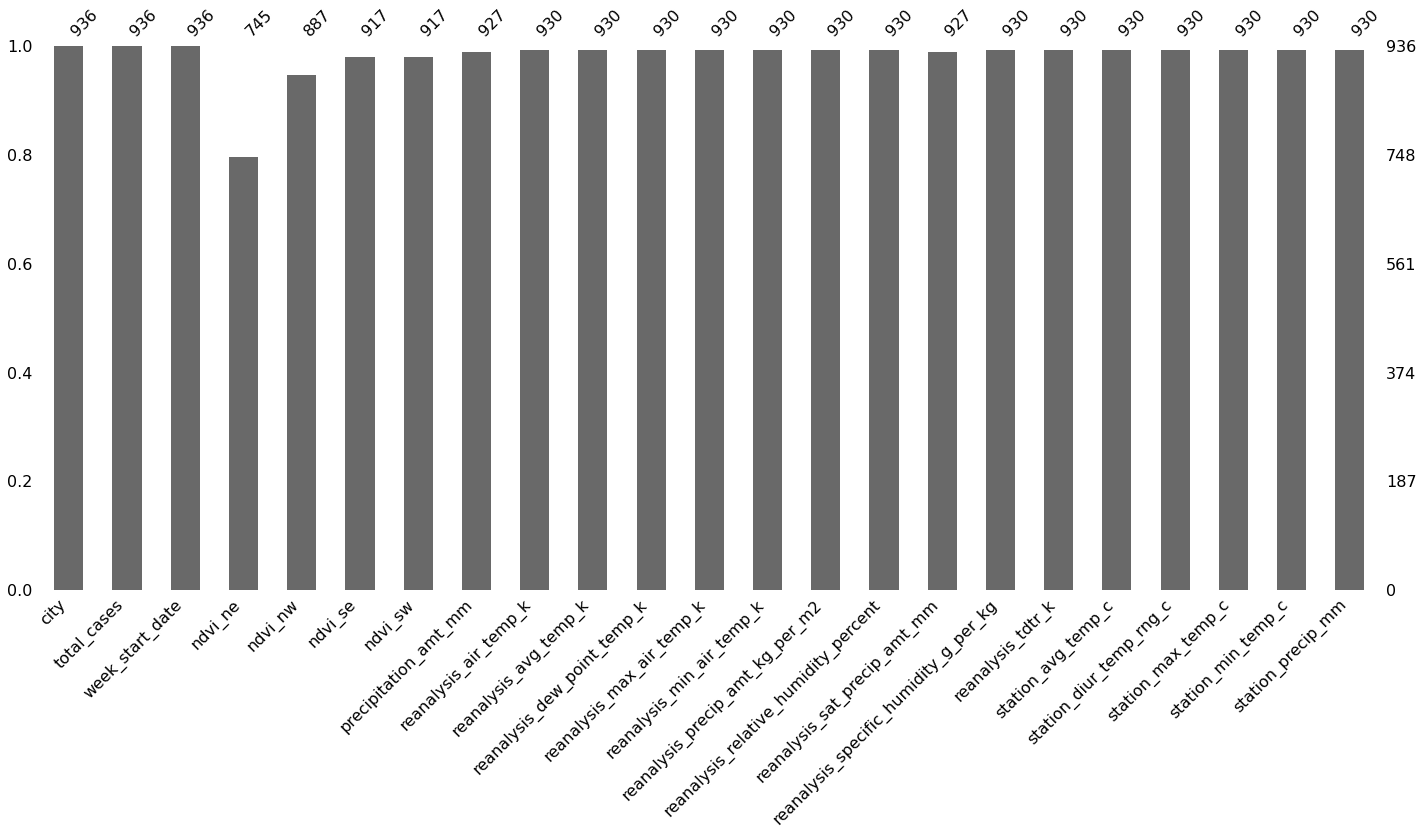

In [21]:
msno.bar(sj)

The highest number of missing values has the variable ndvi_ne – (Normal Difference Vegetation Index) Pixel northeast of the city centroid, followed by the rest of the NDVI variables. The majority of variables have 6 values missing throughout the data frame. What is important to investigate also is the distribution of the missing values and whether they are clustered and/or variable dependent.

<AxesSubplot:>

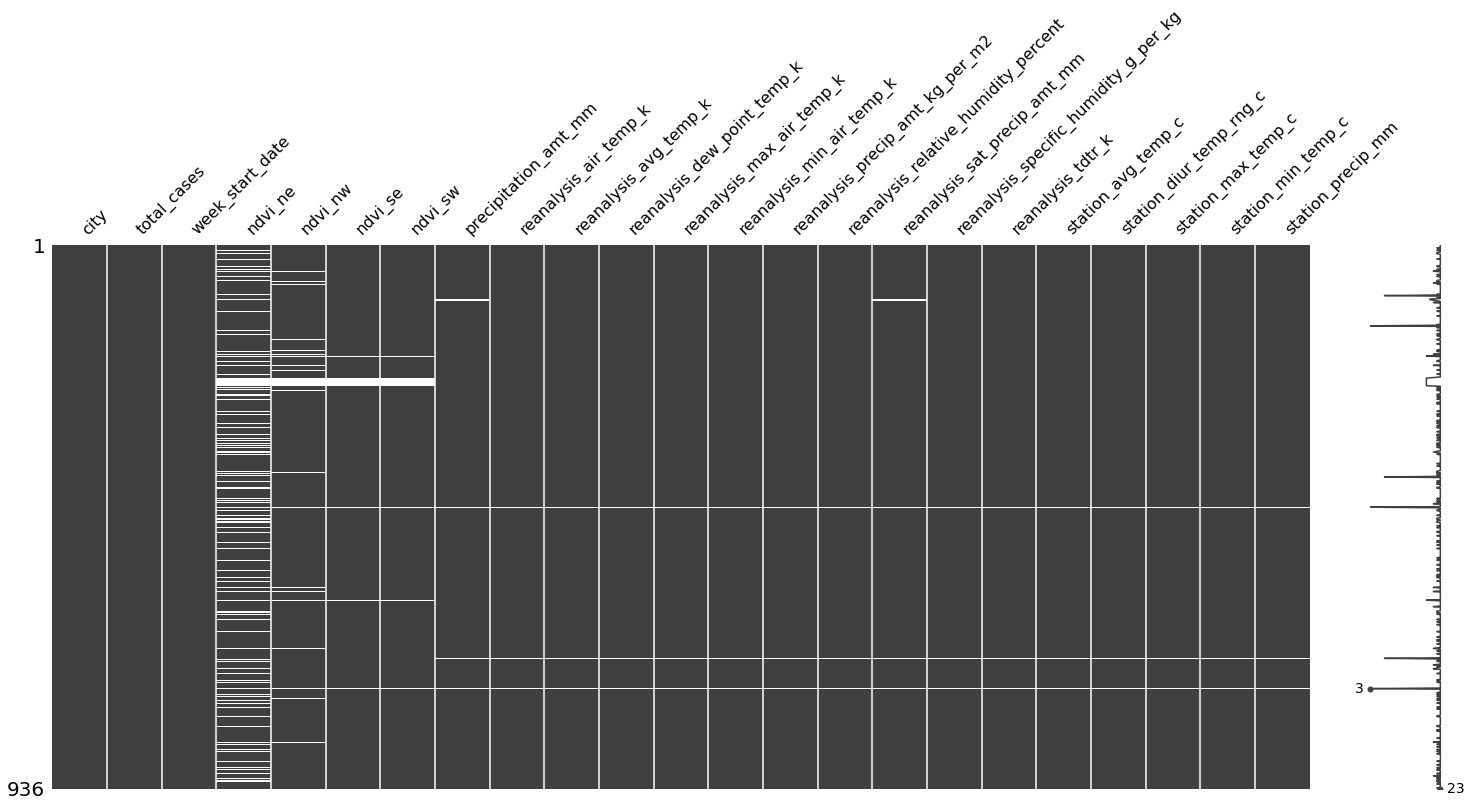

In [22]:
msno.matrix(sj) 

It's easily noticeable that there are several weeks with the vast majority of climate variables absent. For time-series data especially is unwise to impute a constant (the mean or zero), as it is the popular choice with rectangular data. Since all those variables are time dependant, the imputation of the missing values can be a lot more precise and therefore it can introduce way less bias. 

The matrix of missing values also shows us that ndvi_ne has a more or less uniform distribution of missing values. There is a cluster of missing values throughout satellite vegetation features (NDVI variables) that needs a more careful approach.

In [23]:
# print(sj.columns)
fig = px.imshow(sj.corr(), title='Correlation between features')
fig.show()

In [24]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sj.week_start_date, y=sj.ndvi_ne, mode='lines', name='ndvi_ne'))
fig.add_trace(go.Scatter(x=sj.week_start_date, y=sj.ndvi_nw, mode='lines', name='ndvi_nw'))
fig.update_layout(title='Normalized difference vegetation index NE and NW of the city', xaxis_title='Week of the year', yaxis_title = 'NDVI')

The variables ndvi_ne and ndvi_nw are heavily correlated, which is to be expected. ndvi_ne seems to have more variability, therefore the use of higher-order spline might be justified for imputation of missing variables. 

As per usual, any imputation method is more or less guesswork, which introduces bias in the data. 

Both time series have obvious trends and seasonal components. One of the right ways to impute missing data, in this case, would be to decompose series, remove trend and seasonality, impute the data, and then throw the trend and season back in. The other is to model the data as SARIMA (Seasonal AutoRegressive Integrated Moving Average) and calculate missing data from the model directly. We will go back to this procedure if NDVI variables prove to be important for the final predictive model (data snooping danger). For now, the higher-order spline interpolation method will do.

In [25]:
sj_drop_na = sj.ndvi_ne.dropna()
impute_cubic = interp1d(sj_drop_na.index, sj_drop_na, kind='cubic')

fig = go.Figure()
fig.add_trace(go.Scatter(x=sj.week_start_date, y=impute_cubic(sj.ndvi_ne.index), mode='lines', name='ndvi_ne imputed', line=dict(color='MediumPurple', width=2)))
fig.add_trace(go.Scatter(x=sj.week_start_date, y=sj.ndvi_ne, mode='lines', name='ndvi_ne'))
fig.update_layout(autosize=False, width=1700, title='The imputed vs. original NDVI NE', xaxis_title='Week of the year', yaxis_title = 'NDVI')

The same imputation method is applied for the whole sj and iq data. 

In [26]:
columns_to_impute = [e for e in sj.columns if e not in ('city', 'week_start_date')]

for city in [sj, iq]:
    for column in columns_to_impute:
        temp = city[column].dropna()
        impute_cubic = interp1d(temp.index, temp, kind='cubic')
        city[column] = impute_cubic(city[column].index)

sj.to_csv('sj_imputed.csv')
iq.to_csv('iq_imputed.csv')


In [ ]:
The next steps would be to check how features compare to each other and to a number of cases label. As mentioned in the intro Dengue fever is an infective disease, therefore it might be worthwhile to go through correlations between variables at different lags.